# Import modules, libraries, and packages

In [249]:
%load_ext autoreload
%autoreload 2

import os
import sys
from pathlib import Path

# Get the current working directory of the notebook
current_dir = os.getcwd()
# Add the parent directory of the notebook to the Python path
root_dir = Path(current_dir).resolve().parents[2]
sys.path.append(root_dir)

import yaml
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
import geopandas as gpd
import pandas as pd
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Parameters and constants

In [250]:
# Load config_file
with open('config_nh_run_plots.yml', 'r') as ymlfile:
        config_data = yaml.load(ymlfile, Loader=yaml.FullLoader)
        
data_dir = config_data['data_dir']
map_shape_file = os.path.join(data_dir, config_data['map_shape_file'])
hm_catchment = os.path.join(data_dir, config_data['hm_catchment'])
result_dir = Path(config_data['result_dir'])
result_file = config_data['result_file']
# Lower metrics4plotting
config_data['metrics4plotting'] = [metric.lower() for metric in config_data['metrics4plotting']]
metrics4plotting = config_data['metrics4plotting']

case_id = ('_').join(result_file.split('.')[0].split('_')[-2:])
# Lower metrics4table
config_data['metrics4table'] = [metric.lower() for metric in config_data['metrics4table']]

FILTER_BY_447 = False

TRESHOLD_DICT = {
        'nse': 0.0,
        'kge': 0.0,
}

# Functions

In [251]:
def plot_metric_map(result_df, states_reprojected, hm_catchment_gdf_reprojected, 
                    basin_coordinates_reprojected, metric='nse',
                    result_dir=Path('.'),
                    thresholds=TRESHOLD_DICT ):
    
    # Extract data given the metric
    df = result_df[['basin', metric]]
    
    gap = 0.04  # Gap between the line and the text label - histogram
    
    threshold = thresholds.get(metric, None)  # Get the threshold for the given metric, default to 0.0

    print(thresholds[metric])
    print(f"Plotting {metric} map with threshold: {threshold}")

    # Define the colormap based on the metric values
    cmap = plt.cm.gnuplot
    if threshold is not None:
        normalize = mcolors.Normalize(threshold, vmax=1.0)  # Adjust vmax to 1.0
    else:
        normalize = mcolors.Normalize(vmin=df[metric].min(), vmax=df[metric].max())

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(16, 8))

    # Plot USA map
    states_reprojected.boundary.plot(ax=ax, color=None, edgecolor='gray', linewidth=0.7)

    # Plot the catchments with colors based on the metric values
    hm_catchment_gdf_reprojected.boundary.plot(ax=ax, color=None, alpha=0, edgecolor='gray', linewidth=0)

    # Plot circles located at reprojected basin coordinates with colors based on the metric values
    ax.scatter(basin_coordinates_reprojected.geometry.x, basin_coordinates_reprojected.geometry.y,
               s=42,  # size of the circles
               c=df[metric],  # color based on metric values
               cmap=cmap,  # colormap
               linewidth=0,  # width of circle edge
               alpha=0.7)  # transparency

    # Count how many in df[metric] are <= threshold
    if threshold is not None:
        nse_less_than_threshold = df[metric][df[metric] <= threshold].count()
        ax.set_title(f"{metric.upper()} results ({len(df)} basins | ${metric.upper()} \leq {threshold}$: {nse_less_than_threshold} counts)")
    else:
        ax.set_title(f"{metric.upper()} results ({len(df)} basins)")

    # Set entries to be the threshold value if they are less than the threshold
    if threshold is not None:
        df[metric] = df[metric].apply(lambda x: threshold if x <= threshold else x)

    # Remove x and y ticks
    ax.set_xticks([])
    ax.set_yticks([])
    # Get rid of box lines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Create an axis for the colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=-0.3)

    # Set the ticks on the colorbar
    if threshold is not None:
        cbar_ticks = np.linspace(threshold, df[metric].max(), num=5)
    else:
        cbar_ticks = np.linspace(df[metric].min(), df[metric].max(), num=5)
    cbar_ticks = np.round(cbar_ticks, 2)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cax, ticks=cbar_ticks)

    # Add a histogram plot to the colorbar
    hist_values = df[metric].values
    hist_ax = divider.append_axes("right", size="10%", pad=0.6)  # adjust pad as needed

    n_bins = 20
    bins = np.linspace(hist_values.min(), hist_values.max(), n_bins + 1)

    hist_ax.hist(hist_values, bins=bins, orientation='horizontal', color='tab:blue', alpha=0.5)

    hist_ax.set_yticks([])  # remove y-ticks
    hist_ax.set_ylim(hist_values.min(), hist_values.max())  # set y-axis limits to match the data range
    # Adjust the x-ticks
    xticks = hist_ax.get_xticks()
    hist_ax.set_xticks(xticks[::3])  # set the x-ticks to every 3rd value
    hist_ax.set_xlim(0, hist_ax.get_xlim()[1])  # set the right limit to the maximum value
    # Move the x label to the top and adjust ticks
    hist_ax.set_xlabel('')
    hist_ax.xaxis.set_label_position('top')
    hist_ax.set_xlabel('Frequency', labelpad=10)
    hist_ax.xaxis.tick_top()
    hist_ax.tick_params(axis='x', which='both', labeltop=True, labelbottom=False)
    # Get rid of box lines
    hist_ax.spines['top'].set_visible(False)
    hist_ax.spines['right'].set_visible(False)
    hist_ax.spines['bottom'].set_visible(False)
    hist_ax.spines['left'].set_visible(False)

    # Calculate the gap height based on the current ylim
    ylim = hist_ax.get_ylim()
    gap_height = gap * (ylim[1] - ylim[0])

    # Add mean and median value plots to the histogram
    mean_value = np.mean(hist_values)
    median_value = np.median(hist_values)
    max_value = max(mean_value, median_value)  # Find the greatest value

    # Plot mean value
    if mean_value < max_value:
        hist_ax.axhline(mean_value, color='tab:red', linestyle='--', linewidth=2)
        hist_ax.text(hist_ax.get_xlim()[1], mean_value - gap_height, f'Mean: {mean_value:.3f}', va='bottom', ha='right', color='tab:red')
    else:
        hist_ax.axhline(mean_value, color='tab:red', linestyle='--', linewidth=2)
        hist_ax.text(hist_ax.get_xlim()[1], mean_value + gap_height, f'Mean: {mean_value:.3f}', va='top', ha='right', color='tab:red')

    # Plot median value
    if median_value < max_value:
        hist_ax.axhline(median_value, color='green', linestyle='--', linewidth=2)
        hist_ax.text(hist_ax.get_xlim()[1], median_value - gap_height, f'Median: {median_value:.3f}', va='bottom', ha='right', color='green')
    else:
        hist_ax.axhline(median_value, color='green', linestyle='--', linewidth=2)
        hist_ax.text(hist_ax.get_xlim()[1], median_value + gap_height, f'Median: {median_value:.3f}', va='top', ha='right', color='green')

    # Show the plot
    plt.show()

    # Save the plot
    fig.savefig(result_dir / f'{metric}_basins_map.png', dpi=150, bbox_inches='tight')

# Load data

In [252]:
result_df = pd.read_csv(os.path.join(result_dir, result_file))

if FILTER_BY_447:
    # Load list of 447 basins
    basins447_dir = os.path.join('../../experiment_scripts', '447_basin_file.txt')
    with open(basins447_dir) as file:
        basin447 = [int(line.rstrip()) for line in file]
    # Filter the result dataframe to only include the 447 basins
    result_df = result_df[result_df['basin'].isin(basin447)]

# Select numeric columns
numeric_columns = result_df.select_dtypes(include=[np.number]).columns
# Eliminate rows with empty values in the numeric columns
result_df = result_df.dropna(subset=numeric_columns)

# # Truncate the numeric columns by 0 (all negative values are set to 0)
# result_df[numeric_columns] = result_df[numeric_columns].applymap(lambda x: max(0, x))

# # Truncate the 'metric' (NSE) columns by 0 (all negative values are set to 0)
# result_df[metric] = result_df[metric].map(lambda x: max(0, x))

# Clean the basin ID by splitting the string and taking the last element - if the basin ID is string
if isinstance(result_df['basin'].values[0], str):
    result_df['basin'] = result_df['basin'].apply(lambda x: int(x.split('_')[-1]))

# Lower case the column names
result_df.columns = result_df.columns.str.lower()


In [253]:
# Load basin coordinates (hm_catchment)
hm_catchment_gdf = gpd.read_file(hm_catchment)

display(hm_catchment_gdf.head())

,hru_id,ann_P,lon_cen,lat_cen,AREA,elev_mean,ave_T,july_T,Perimeter,geometry
0,1013500,0.0,-68.56551,47.01169,2.303988e+09,277.493490,None,None,647993,"MULTIPOLYGON (((-68.35650 46.90311, -68.35612 ..."
1,1022500,0.0,-68.07313,44.79691,6.203873e+08,103.604200,None,None,312624,"POLYGON ((-67.97836 44.61310, -67.97800 44.613..."
2,1030500,0.0,-68.14985,45.80527,3.676155e+09,174.433896,None,None,662248,"MULTIPOLYGON (((-67.83991 45.36614, -67.83955 ..."
3,1031500,0.0,-69.58119,45.23568,7.665447e+08,304.743490,None,None,309614,"MULTIPOLYGON (((-69.33810 45.12317, -69.33800 ..."
4,1047000,0.0,-70.16213,44.98744,9.049562e+08,379.779978,None,None,310157,"POLYGON ((-70.10847 45.21669, -70.10858 45.216..."


In [254]:
# Filter hm_catchment_gdf to only include the HRU_IDs in the hm_catchment['basin'] column
hm_catchment_gdf = hm_catchment_gdf[hm_catchment_gdf['hru_id'].isin(result_df['basin'])]
hm_catchment_gdf.head()

,hru_id,ann_P,lon_cen,lat_cen,AREA,elev_mean,ave_T,july_T,Perimeter,geometry
1,1022500,0.0,-68.07313,44.79691,6.203873e+08,103.604200,None,None,312624,"POLYGON ((-67.97836 44.61310, -67.97800 44.613..."
3,1031500,0.0,-69.58119,45.23568,7.665447e+08,304.743490,None,None,309614,"MULTIPOLYGON (((-69.33810 45.12317, -69.33800 ..."
4,1047000,0.0,-70.16213,44.98744,9.049562e+08,379.779978,None,None,310157,"POLYGON ((-70.10847 45.21669, -70.10858 45.216..."
5,1052500,0.0,-71.17197,44.96168,3.961103e+08,646.073604,None,None,172588,"POLYGON ((-71.10862 45.12730, -71.10825 45.127..."
6,1054200,0.0,-71.05872,44.31072,1.813287e+08,629.165746,None,None,111995,"POLYGON ((-70.97999 44.39574, -70.97963 44.395..."


# Plot results

In [255]:
# Define the CRS of your original data (if it's not already defined)
original_crs = 'EPSG:4326'  # Assuming WGS84 geographic CRS

states = gpd.read_file(map_shape_file)
# Set the CRS for the GeoDataFrame
states.crs = original_crs

# Define the new CRS you want to reproject to, for example, an Albers Equal Area projection
target_crs = 'ESRI:102008'  # ESRI:102008 is the WKID for the Albers Equal Area projection

# Reproject the GeoDataFrame
states_reprojected = states.to_crs(target_crs)

# Reproject the catchment GeoDataFrame
hm_catchment_gdf_reprojected = hm_catchment_gdf.to_crs(states_reprojected.crs)

# Reproject the coordinates of the circles
basin_coordinates_reprojected = gpd.points_from_xy(hm_catchment_gdf['lon_cen'], hm_catchment_gdf['lat_cen'], crs='EPSG:4326')
basin_coordinates_reprojected = gpd.GeoDataFrame(geometry=basin_coordinates_reprojected, crs='EPSG:4326')
basin_coordinates_reprojected = basin_coordinates_reprojected.to_crs(states_reprojected.crs)

## Metrics-Map

0.0
Plotting nse map with threshold: 0.0


/tmp/ipykernel_3668904/3580641887.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[metric] = df[metric].apply(lambda x: threshold if x <= threshold else x)


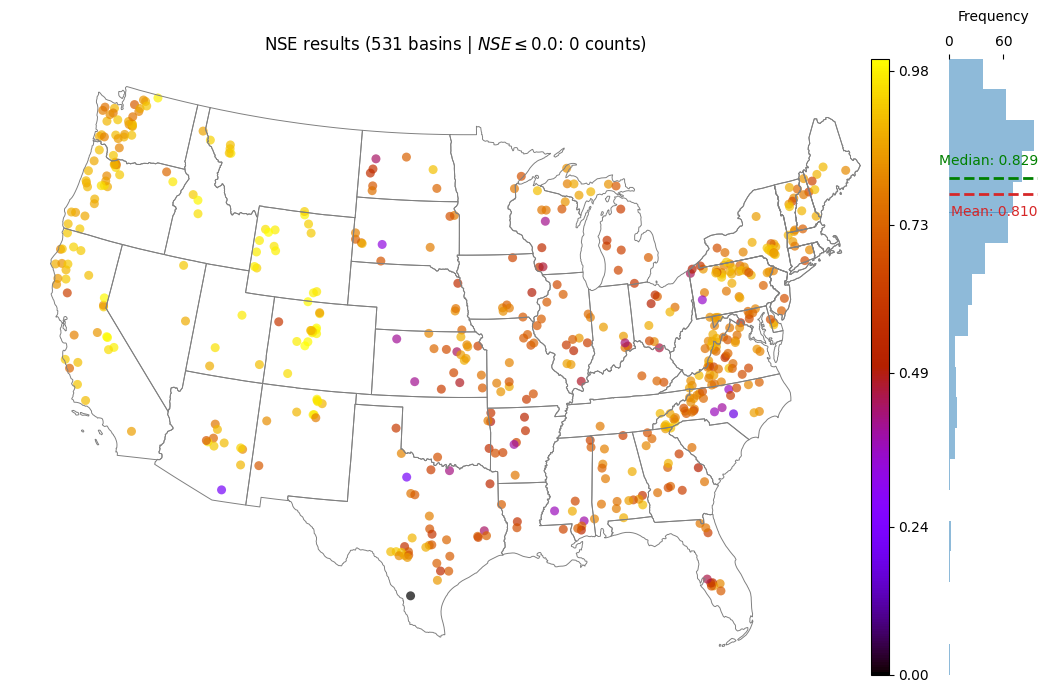

0.0
Plotting kge map with threshold: 0.0


/tmp/ipykernel_3668904/3580641887.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[metric] = df[metric].apply(lambda x: threshold if x <= threshold else x)


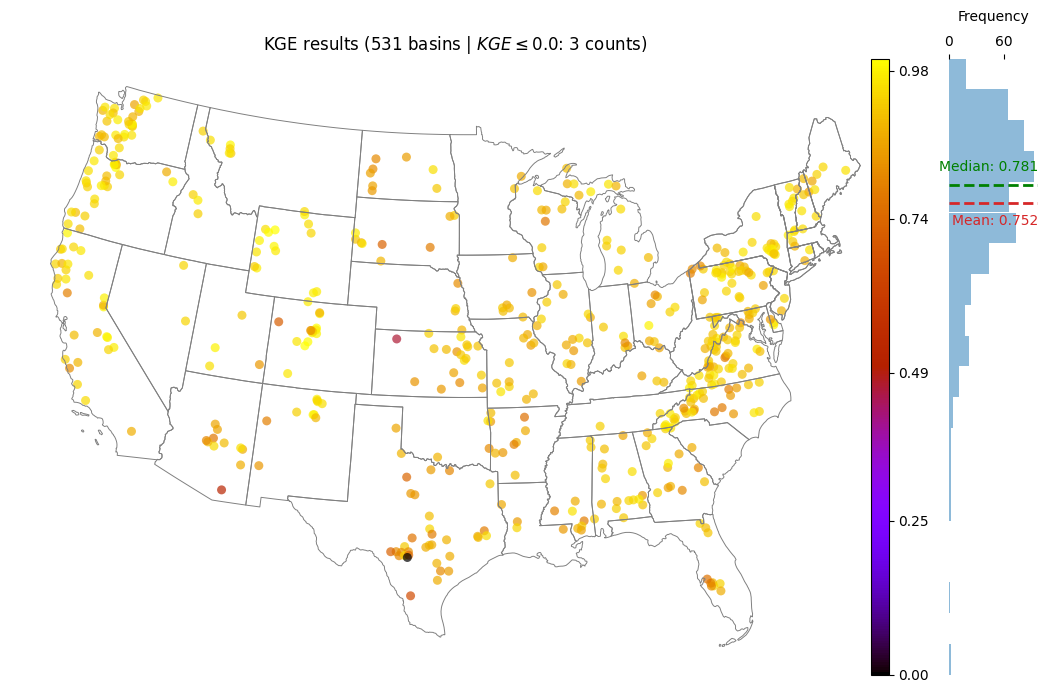

In [256]:
for metric in metrics4plotting:
    plot_metric_map(result_df, states_reprojected, hm_catchment_gdf_reprojected, 
                    basin_coordinates_reprojected, 
                    metric=metric, 
                    result_dir=result_dir,
                    thresholds=TRESHOLD_DICT)

# Tables

In [257]:
# Read the CSV files
data = {}
for file_name in config_data['files4table']:
    data[file_name] = pd.read_csv(os.path.join(result_dir, file_name))
    
# Initialize an empty dictionary to store statistics
statistics = {}

# Calculate statistics for each model
for file_name, df in data.items():
    
    # Lowercase the column names
    df.columns = df.columns.str.lower() 
    # '_' to '-' in column names
    df.columns = df.columns.str.replace('_', '-') 
    
    case_id = ('_').join(file_name.split('.')[0].split('_')[-2:])
    
    # If NSE is in the columns, count the number of basins with NSE < 0 and exclude those rows after
    if 'nse' in df.columns:
        n_basins = df.shape[0]
        n_basins_nse_lt_0 = df[df['nse'] <= 0].shape[0]
        df = df[df['nse'] > 0]
        median = df['nse'].median()
        mean = df['nse'].mean()
        statistics[case_id] = {'nse': {
            'median': median,
            'mean': mean,
        }}
        statistics[case_id]['n_basins_nse_lt_0'] = n_basins_nse_lt_0
    
    # For each metric, find median- for NSE calculate mean, and number of basins with NSE < 0 (exclude those from all the statistics)
    for met in config_data['metrics4table']:
        
        met = met.lower()
        # Compute the statistics
        if met != 'nse':
            median = df[met].median()
            statistics[case_id][met] = {
                'median': median,
            }

# Create DataFrame from statistics dictionary
df_statistics = pd.DataFrame(statistics).transpose()

In [275]:
# Convert data to DataFrame
df_statistics = pd.DataFrame(statistics).T

# Convert nested dictionaries to individual columns
df_statistics['nse_mean'] = df_statistics['nse'].apply(lambda x: round(x['mean'], 3))
df_statistics['nse_median'] = df_statistics['nse'].apply(lambda x: round(x['median'], 3))
df_statistics['n_basins_nse_lt_0_count'] = df_statistics['n_basins_nse_lt_0']
df_statistics['alpha-nse_median'] = df_statistics['alpha-nse'].apply(lambda x: round(x['median'], 3))
df_statistics['beta-nse_median'] = df_statistics['beta-nse'].apply(lambda x: round(x['median'], 3))
df_statistics['fhv_median'] = df_statistics['fhv'].apply(lambda x: round(x['median'], 1))
df_statistics['fms_median'] = df_statistics['fms'].apply(lambda x: round(x['median'], 1))
df_statistics['flv_median'] = df_statistics['flv'].apply(lambda x: round(x['median'], 1))

# Drop unnecessary columns
df_statistics.drop(columns=['nse', 'n_basins_nse_lt_0', 'alpha-nse', 'beta-nse', 'fhv', 'fms', 'flv'], inplace=True)

# Ensure the 'n_basins_nse_lt_0_count' column is numeric
df_statistics['n_basins_nse_lt_0_count'] = pd.to_numeric(df_statistics['n_basins_nse_lt_0_count'])

# Ensure only numerical columns are selected for mean calculation
numeric_cols = df_statistics.select_dtypes(include=['float64', 'int']).columns

# Add a row for the mean values of the statistics
mean_values = df_statistics.loc[df_statistics.index != 'ensemble_metrics', numeric_cols].mean()
# Round the mean values to 3 decimal places
mean_values = mean_values.round(3)

# Create a new DataFrame for the mean values
df_mean = pd.DataFrame(mean_values).transpose()
df_mean.index = ['seeds_mean']

# Add the std values to the DataFrame
std_values = df_statistics.loc[df_statistics.index != 'ensemble_metrics', numeric_cols].std()
# Round the std values to 3 decimal places
std_values = std_values.round(3)

# Create a new DataFrame for the std values
df_std = pd.DataFrame(std_values).transpose()
df_std.index = ['seeds_std']

# Insert the mean row before the 'ensemble_metrics' row
idx = df_statistics.index.get_loc('ensemble_metrics')
df_statistics = pd.concat([df_statistics.iloc[:idx], df_mean, df_std, df_statistics.iloc[idx:]])

# Convert DataFrame to LaTeX table format
latex_table = df_statistics.to_latex(
    index=True,
    header=True,
    float_format="%.3f"
)

print(latex_table)

\begin{tabular}{lrrrrrrrr}
\toprule
 & nse_mean & nse_median & n_basins_nse_lt_0_count & alpha-nse_median & beta-nse_median & fhv_median & fms_median & flv_median \\
\midrule
1111 & 0.773 & 0.806 & 1.000 & 0.882 & -0.004 & -12.300 & -13.900 & -28.100 \\
2222 & 0.774 & 0.797 & 0.000 & 0.843 & -0.013 & -16.100 & -11.800 & -52.800 \\
3333 & 0.773 & 0.799 & 1.000 & 0.857 & -0.009 & -13.800 & -15.100 & -42.500 \\
4444 & 0.774 & 0.798 & 1.000 & 0.877 & -0.009 & -12.300 & -10.300 & -48.200 \\
5555 & 0.772 & 0.799 & 0.000 & 0.909 & 0.001 & -10.200 & -12.800 & -64.700 \\
6666 & 0.767 & 0.791 & 1.000 & 0.854 & -0.007 & -14.700 & -16.800 & -30.000 \\
7777 & 0.767 & 0.795 & 0.000 & 0.874 & -0.006 & -12.600 & -14.000 & -35.300 \\
8888 & 0.764 & 0.789 & 1.000 & 0.846 & -0.022 & -15.300 & -14.300 & -40.700 \\
seeds_mean & 0.771 & 0.797 & 0.625 & 0.868 & -0.009 & -13.412 & -13.625 & -42.788 \\
seeds_std & 0.004 & 0.005 & 0.518 & 0.022 & 0.007 & 1.929 & 2.000 & 12.244 \\
ensemble_metrics & 0.810 & 0.82